In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

from lib.data.datareader_total import DataReaderTotal
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_fit3d import DataReaderFIT3D
from lib.utils.args import get_opts_args
from lib.model.load_model import load_model
from lib.model.load_dataset import load_dataset
from lib.data.dataset_motion_3d import MotionDataset3DTotal
from lib.model.evaluation import *

### Load data_type

In [7]:
dataset_name = 'h36m'
overwrite_list = []
source_list                    = load_data(dataset_name=dataset_name, data_type='source_list', overwrite_list=overwrite_list)
cam_params                     = load_data(dataset_name=dataset_name, data_type='cam_param', overwrite_list=overwrite_list)
world_3ds                      = load_data(dataset_name=dataset_name, data_type='world_3d', overwrite_list=overwrite_list)
cam_3ds                        = load_data(dataset_name=dataset_name, data_type='cam_3d', overwrite_list=overwrite_list)
img_2ds                        = load_data(dataset_name=dataset_name, data_type='img_2d', overwrite_list=overwrite_list)
img_3ds                        = load_data(dataset_name=dataset_name, data_type='img_3d', overwrite_list=overwrite_list)
scale_factors                  = load_data(dataset_name=dataset_name, data_type='scale_factor', overwrite_list=overwrite_list)
img_25ds                       = load_data(dataset_name=dataset_name, data_type='img_25d', overwrite_list=overwrite_list)
cam_3d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
cam_3d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
cam_3d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)
img_2d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
img_2d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
img_2d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)

==> Loading H36M source_list... overwrite: False
==> Loading H36M cam_param... overwrite: False
==> Loading H36M world_3d... overwrite: False
==> Loading H36M cam_3d... overwrite: False
==> Loading H36M img_2d... overwrite: False
==> Loading H36M img_3d... overwrite: False
==> Loading H36M scale_factor... overwrite: False
==> Loading H36M img_25d... overwrite: False
==> Loading H36M cam_3d_canonical_same_z... overwrite: False
==> Loading H36M cam_3d_canonical_same_dist... overwrite: False
==> Loading H36M cam_3d_canonical_fixed_dist_5... overwrite: False
==> Loading H36M img_2d_canonical_same_z... overwrite: False
==> Loading H36M img_2d_canonical_same_dist... overwrite: False
==> Loading H36M img_2d_canonical_fixed_dist_5... overwrite: False


In [3]:
# check constraints
for source in source_list:
    subject, cam_id, action = split_source_name(source, dataset_name)
    world_3d = world_3ds[subject][action]
    cam_3d = cam_3ds[subject][action][cam_id]
    img_2d = img_2ds[subject][action][cam_id]
    img_3d = img_3ds[subject][action][cam_id]
    cam_3d_canonical_same_z = cam_3d_canonicals_same_z[subject][action][cam_id]
    cam_3d_canonical_same_dist = cam_3d_canonicals_same_dist[subject][action][cam_id]
    cam_3d_canonical_fixed_dist_5 = cam_3d_canonicals_fixed_dist_5[subject][action][cam_id]
    assert world_3d.shape[1:] == (17, 3), f'{source} {world_3ds[subject][action].shape}'
    assert world_3d.mean() < 5, f'{source} {world_3d.mean()}'
    assert cam_3d.shape[1:] == (17, 3), f'{source} {cam_3d.shape}'
    assert cam_3d.mean() < 5, f'{source} {cam_3d.mean()}'
    assert img_2d.mean() > 1, f'{source} {img_2d.mean()}'
    assert np.allclose(img_2d, img_3d[...,:2]), f'image 2d and 3d are not equal'
    assert np.allclose(cam_3d[...,2], cam_3d_canonical_same_z[...,2]), 'Z values should be same'
    assert np.allclose(np.linalg.norm(cam_3d[:, 0], axis=1), cam_3d_canonical_same_dist[:, 0, 2]), 'Distances should be same'
    assert np.allclose(np.array([5.0]*len(cam_3d)), cam_3d_canonical_fixed_dist_5[:, 0, 2]), 'Distances should be same'

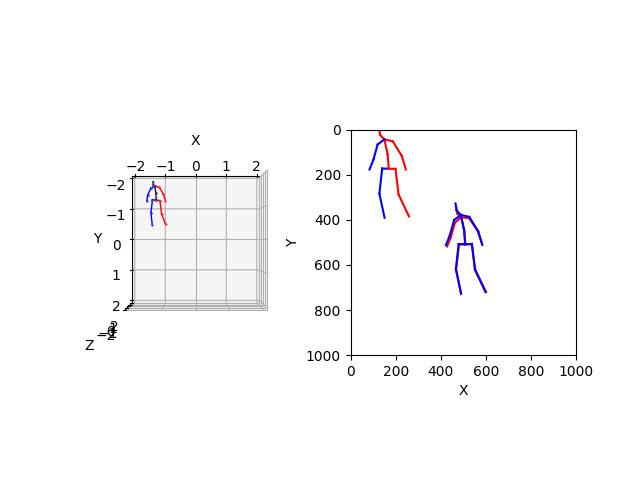

In [24]:
source = 'S11_55011271_Walking'
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = cam_params[subject][action][cam_id]
W, H, intrinsic, extrinsic, R, t, C, = cam_param['W'], cam_param['H'], cam_param['intrinsic'], cam_param['extrinsic'], cam_param['R'], cam_param['t'], cam_param['C']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

frame_num = -1
cam_3d = cam_3ds[subject][action][cam_id][frame_num].copy()
cam_3d += np.array([-1, -1, 0])
#cam_3d[:, 1] -= cam_3d[0, 1]
cam_3d_canonicalized = cam_3d.copy()
cam_3d_canonicalized[:, 0] -= cam_3d_canonicalized[0, 0]
cam_3d_canonicalized[:, 1] -= cam_3d_canonicalized[0, 1]


img_2d = cam_3d @ intrinsic.T
img_2d = img_2d / img_2d[:, 2:]

img_2d_canonicalized = cam_3d_canonicalized @ intrinsic.T
img_2d_canonicalized = img_2d_canonicalized / img_2d_canonicalized[:, 2:]

yaw = np.arctan2(cam_3d[0, 0], cam_3d[0, 2])
rotmat_yaw = Rotation.from_rotvec([0, -yaw, 0]).as_matrix()
pitch = np.arctan2(cam_3d[0, 1], cam_3d[0, 2])
rotmat_pitch = Rotation.from_rotvec([pitch, 0, 0]).as_matrix()
cam_3d_canonicalized_rotated = cam_3d_canonicalized.copy()
cam_3d_canonicalized_rotated = rotate_torso_by_R(cam_3d_canonicalized_rotated, rotmat_yaw)
cam_3d_canonicalized_rotated = rotate_torso_by_R(cam_3d_canonicalized_rotated, rotmat_pitch)

img_2d_canonicalized_rotated = cam_3d_canonicalized_rotated @ intrinsic.T
img_2d_canonicalized_rotated = img_2d_canonicalized_rotated / img_2d_canonicalized_rotated[:, 2:]

img_2d_centered = img_2d.copy()
img_2d_centered -= img_2d_centered[0]
img_2d_centered += np.array([cx, cy, 0])

fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig, loc=121, mode='cam')
ax2 = axes_2d(fig, loc=122, W=W, H=H)
draw_3d_pose(ax, cam_3d)
draw_2d_pose(ax2, img_2d, W=W, H=W)
#draw_2d_pose(ax2, img_2d_canonicalized, W=W, H=W, color='g')
draw_2d_pose(ax2, img_2d_canonicalized_rotated, W=W, H=W, color='r')
draw_2d_pose(ax2, img_2d_centered, W=W, H=W, color='b')
plt.show()

In [4]:
dist_from_origin_orig = np.linalg.norm(cam_3d, axis=1)
dist_from_origin_orig

array([4.89824497, 4.97531716, 4.98078433, 5.16421564, 4.82390045,
       4.79702915, 5.01294003, 4.90069289, 4.86944194, 4.80273941,
       4.81051751, 4.79171604, 4.76923106, 4.73688189, 4.95552197,
       5.06169823, 4.93870543])

In [12]:
cam_3d_inversed = img_2d_centered.copy()
cam_3d_inversed += np.array([0, 0, 1])
cam_3d_inversed -= np.array([cx, cy, 0])
cam_3d_inversed /= np.array([fx, fy, 1])
cam_3d_inversed *= cam_3d[:, 2:] # dist_from_origin_orig[:, None]
img_2d_inversed = cam_3d_inversed @ intrinsic.T
#img_2d_inversed = img_2d_inversed / img_2d_inversed[:, 2:]

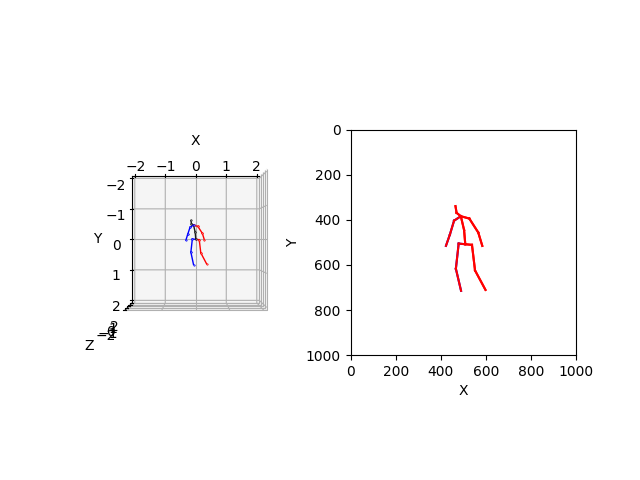

In [14]:
fig = plt.figure(1)
fig.clear()
ax = axes_3d(fig, loc=121, mode='cam')
ax2 = axes_2d(fig, loc=122, W=W, H=H)
draw_3d_pose(ax, cam_3d_inversed)
draw_2d_pose(ax2, img_2d_inversed, W=W, H=W)
draw_2d_pose(ax2, img_2d_centered, W=W, H=W, color='r')
plt.show()

In [10]:
cam_3d_hat = cam_3d - cam_3d[0]
cam_3d_inversed_hat = cam_3d_inversed - cam_3d_inversed[0]

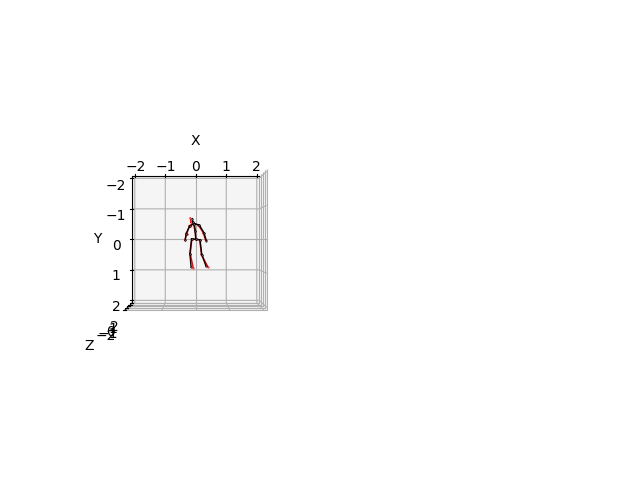

In [11]:
fig = plt.figure(2)
fig.clear()
ax = axes_3d(fig, loc=121, mode='cam')
draw_3d_pose(ax, cam_3d_inversed_hat, color='r')
draw_3d_pose(ax, cam_3d_hat, color='k')
plt.show()

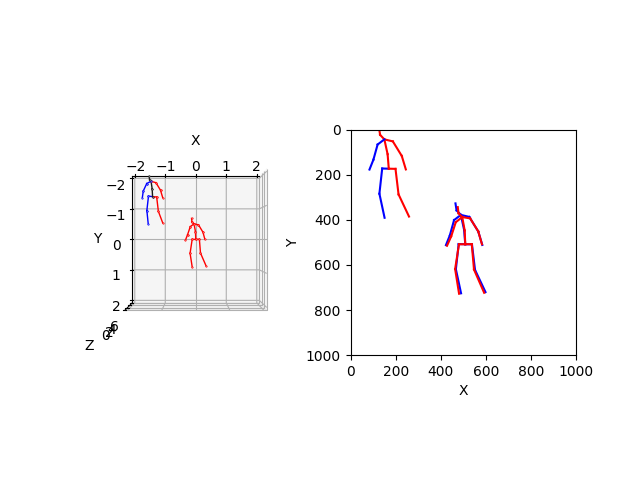

In [49]:
source = 'S11_55011271_Walking'
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = cam_params[subject][action][cam_id]
W, H, intrinsic, extrinsic, R, t, C, = cam_param['W'], cam_param['H'], cam_param['intrinsic'], cam_param['extrinsic'], cam_param['R'], cam_param['t'], cam_param['C']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

frame_num = -1
cam_3d = cam_3ds[subject][action][cam_id][frame_num].copy()
cam_3d += np.array([-1, -1, 0])
dist = np.linalg.norm(cam_3d, axis=1)[0]
depth = cam_3d[0, 2]
src_vec = cam_3d[0]
tar_vec = np.array([0, 0, dist])
rotmat = rotation_matrix_from_vectors(src_vec, tar_vec)
cam_3d_canonicalized = cam_3d.copy()
cam_3d_canonicalized -= cam_3d_canonicalized[0]
cam_3d_canonicalized = rotate_torso_by_R(cam_3d_canonicalized, rotmat)
cam_3d_canonicalized += np.array([0, 0, depth])

img_2d = cam_3d @ intrinsic.T
img_2d = img_2d / img_2d[:, 2:]

img_2d_centered = img_2d.copy()
img_2d_centered -= img_2d_centered[0]
img_2d_centered += np.array([cx, cy, 0])

img_2d_canonicalized = cam_3d_canonicalized @ intrinsic.T
img_2d_canonicalized = img_2d_canonicalized / img_2d_canonicalized[:, 2:]

fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig, loc=121, mode='cam')
ax.set_zlim(0, 6)
ax2 = axes_2d(fig, loc=122, W=W, H=H)
draw_3d_pose(ax, cam_3d)
draw_3d_pose(ax, cam_3d_canonicalized, color='r')
draw_2d_pose(ax2, img_2d, W=W, H=W)
draw_2d_pose(ax2, img_2d_centered, W=W, H=W, color='b')
draw_2d_pose(ax2, img_2d_canonicalized, W=W, H=W, color='r')
plt.show()

In [41]:
dist, depth

(5.072278732413426, 4.684761486249346)